<h1>Image Depth Estimation<h1>

# Problem 1: Pixel-wise matching method

## 1.1 Prepare images

In [3]:
!gdown 14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ

Downloading...
From: https://drive.google.com/uc?id=14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ
To: /content/tsukuba.zip
100% 354k/354k [00:00<00:00, 25.2MB/s]


In [4]:
!unzip -q tsukuba.zip -d tsukuba

mapname:  conversion of  failed


In [5]:
!gdown 1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn

Downloading...
From: https://drive.google.com/uc?id=1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn
To: /content/Aloe_images.zip
100% 1.32M/1.32M [00:00<00:00, 43.1MB/s]


In [6]:
!unzip -q Aloe_images.zip

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def l1(x, y):
  return abs(x - y)
def l2(x, y):
  return (x - y) ** 2
def read_image(filepath):
    return cv2.imread(filepath, 0).astype(np.float64)




## 1.2 Calculate disparity map

In [25]:
def cal_depth_map_using_pixel_wise_matching(lelf_image_path, right_image_path, disparity_range, distance_function, scale = 10):
    left_image = read_image(lelf_image_path)
    right_image = read_image(right_image_path)
    height, width = left_image.shape
    disparity_map = np.full((height, width, disparity_range), disparity_range-1, dtype=np.float32)
    for j in range(disparity_range):
        left_d = left_image[:, j:width]
        right_d = right_image[:, 0:width-j]
        disparity_map[:, j:width, j] = distance_function(left_d, right_d)
    min_disparity_map = np.argmin(disparity_map, axis=2)
    depth_map = scale * min_disparity_map
    depth_map = depth_map.astype(np.uint8)
    return depth_map

In [26]:
left_image_path = '/content/tsukuba/left.png'
right_image_path = '/content/tsukuba/right.png'
disparity_range = 16
distance_function = l1
scale = 10
depth_map = cal_depth_map_using_pixel_wise_matching(left_image_path, right_image_path, disparity_range, distance_function, scale)

In [27]:
depth_map.shape

(288, 384)

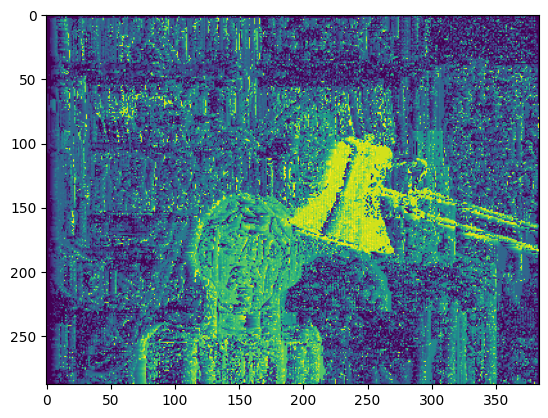

In [28]:
plt.imshow(depth_map)

# Problem 2: Windown-based matching method

In [29]:
def cal_depth_map_using_windown_based_matching(lelf_image_path, right_image_path, disparity_range, windown_size, distance_function, scale = 10):
    left_image = read_image(lelf_image_path)
    right_image = read_image(right_image_path)
    height, width = left_image.shape
    disparity_map = np.full((height, width, disparity_range), (disparity_range-1), dtype=np.float32)

    half_size = windown_size // 2
    for k in range(disparity_range):
        for i in range(half_size + k, height-half_size):
            for j in range(half_size, width-half_size):
                left_windown = left_image[i-half_size:i+half_size+1, j-half_size:j+half_size+1]
                right_windown = right_image[i-k-half_size:i-k+half_size+1, j-half_size:j+half_size+1]
                disparity_map[i, j, k] = np.sum(distance_function(left_windown, right_windown))

    min_disparity_map = np.argmin(disparity_map, axis=2)
    depth_map = 10 * min_disparity_map
    depth_map = depth_map.astype(np.uint8)
    return depth_map




In [31]:
left_image_path = '/content/Aloe/Aloe_left_1.png'
right_image_path = '/content/Aloe/Aloe_right_1.png'
disparity_range = 16
distance_function = l1
scale = 5
windown_size = 3
depth_map = cal_depth_map_using_windown_based_matching(left_image_path, right_image_path, disparity_range, windown_size, distance_function, scale)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,  10,  10, ...,  10,  10,   0],
       [  0,  20,  20, ...,  20,  20,   0],
       ...,
       [  0,  50,  50, ..., 150, 100,   0],
       [  0,  60,  50, ..., 150, 150,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
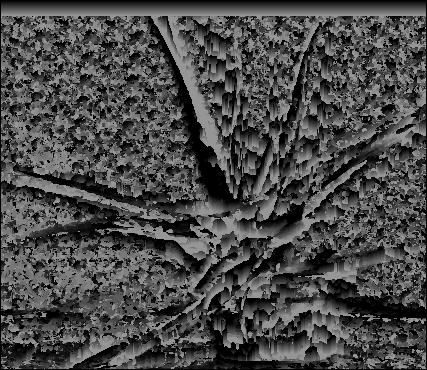

In [32]:
depth_map

# Problem 3: Windown-based matching method with Cosine similarity

In [33]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


In [34]:
def cal_depth_map_with_cosine_similarity(lelf_image_path, right_image_path, disparity_range, windown_size, distance_function, scale = 10):
    left_image = read_image(lelf_image_path)
    right_image = read_image(right_image_path)
    height, width = left_image.shape
    disparity_map = np.full((height, width, disparity_range), (disparity_range-1), dtype=np.float32)

    half_size = windown_size // 2
    for k in range(disparity_range):
        for i in range(half_size + k, height-half_size):
            for j in range(half_size, width-half_size):
                left_windown = left_image[i-half_size:i+half_size+1, j-half_size:j+half_size+1]
                right_windown = right_image[i-k-half_size:i-k+half_size+1, j-half_size:j+half_size+1]
                left_vector= left_windown.flatten()
                right_vector = right_windown.flatten()
                disparity_map[i, j, k] = distance_function(left_vector, right_vector)

    min_disparity_map = np.argmax(disparity_map, axis=2)
    depth_map = 10 * min_disparity_map
    depth_map = depth_map.astype(np.uint8)
    return depth_map




In [35]:
left_image_path = '/content/Aloe/Aloe_left_1.png'
right_image_path = '/content/Aloe/Aloe_right_1.png'
disparity_range = 16
distance_function = cosine_similarity
scale = 5
windown_size = 3
depth_map = cal_depth_map_with_cosine_similarity(left_image_path, right_image_path, disparity_range, windown_size, distance_function, scale)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,  10,  10, ...,  10,  10,   0],
       [  0,  20,  20, ...,  20,  20,   0],
       ...,
       [  0,  30, 130, ...,  20,  20,   0],
       [  0,  60,  60, ...,  60,  70,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
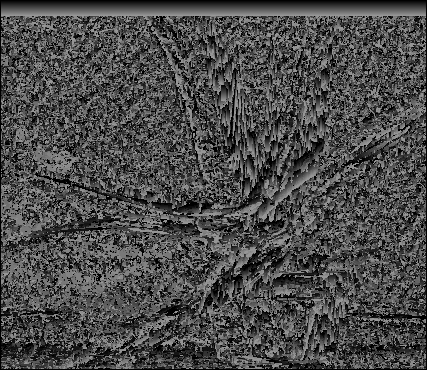

In [36]:
depth_map